In [1]:
import pyes
import elasticsearch

es_address='140.118.155.14:9200'
conn = pyes.es.ES(es_address)
bq = pyes.query.BoolQuery() 
#q = pyes.query.MatchAllQuery()

cve = pyes.query.TermQuery(field="text", value="cve")
vul = pyes.query.TermQuery(field="text", value="vulnerability")
exp = pyes.query.TermQuery(field="text", value="exploit")
back = pyes.query.TermQuery(field="text", value="backdoor")
apt = pyes.query.TermQuery(field="text", value="apt")
mal = pyes.query.TermQuery(field="text", value="malware")


ESR = pyes.ESRange(field="created_at_linux_timestamp", from_value="1388534400000", to_value="1420070400000", 
                   include_lower=True ,include_upper=False)
rq = pyes.query.RangeQuery(qrange=ESR)

bq.add_should(cve)
bq.add_should(vul)
bq.add_should(exp)
bq.add_should(back)
bq.add_should(apt)
bq.add_should(mal)
bq.add_must(rq)

result = conn.search(query=bq , indices='twitter2' , doc_types='tweet') 
len(result)

3822

In [2]:
from collections import defaultdict
twitters = set()
twitterPerMon = defaultdict(set)
tweetsPerMon = [0]*12
indicators = defaultdict(list)
twitterFollower = dict()
twitterFriend = dict()
twitterList = dict()

In [3]:
import datetime
import re

haveUrl = 0
        
regex = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
for oneTweet in result:
    twitters.add(oneTweet['user']['id'])
    month = int(datetime.datetime.fromtimestamp(oneTweet['created_at_linux_timestamp']/1000).strftime('%Y-%m-%d %H:%M:%S').split('-')[1])
    twitterPerMon[month - 1].add(oneTweet['user']['id'])
    tweetsPerMon[month - 1] += 1
    if regex.findall(oneTweet['text']):
        #print(regex.findall(oneTweet['text']))
        haveUrl += 1
    if oneTweet['user']['id'] not in indicators.iterkeys():
        indicators[oneTweet['user']['id']].append(1)
        indicators[oneTweet['user']['id']].append(0)
        indicators[oneTweet['user']['id']].append(0)
    else:
        indicators[oneTweet['user']['id']][0] += 1
        indicators[oneTweet['user']['id']][1] += oneTweet['retweet_count']
        indicators[oneTweet['user']['id']][2] += oneTweet['favorite_count']
        
    if oneTweet['user']['name'] not in twitterFollower.iterkeys():
        twitterFollower[oneTweet['user']['name']] = 0
    else:
        if twitterFollower[oneTweet['user']['name']] < oneTweet['user']['followers_count']:
            twitterFollower[oneTweet['user']['name']] = oneTweet['user']['followers_count']
            
    if oneTweet['user']['name'] not in twitterFriend.iterkeys():
        twitterFriend[oneTweet['user']['name']] = 0
    else:
        if twitterFriend[oneTweet['user']['name']] < oneTweet['user']['friends_count']:
            twitterFriend[oneTweet['user']['name']] = oneTweet['user']['friends_count']
            
    if oneTweet['user']['name'] not in twitterList.iterkeys():
        twitterList[oneTweet['user']['name']] = 0
    else:
        if twitterList[oneTweet['user']['name']] < oneTweet['user']['listed_count']:
            twitterList[oneTweet['user']['name']] = oneTweet['user']['listed_count']

noUrl = len(result) - haveUrl
print (len(twitters))
#print (twitterPerMon)
#print (tweetsPerMon)
#print (haveUrl, noUrl)
#print (indicators)
#len(indicators)
#print(twitterFollower)

91


In [4]:
from bokeh.charts import BoxPlot, Donut, Bar, output_notebook, show
from bokeh.charts.attributes import cat
sort=False
# best support is with data in a format that is table-like
data = {
    'tweets': tweetsPerMon,
    'label' : ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    'twitter' : [len(twitter) for index, twitter in twitterPerMon.items() ]
}
print (data)

twitter = Bar(data, values='twitter', label=cat(columns='label', sort=False), title="Twitter Per Month")

tweet = Bar(data, values='tweets', label=cat(columns='label', sort=False), agg='mean', title="Tweets Per Month")


output_notebook()
show(twitter)
show(tweet)

{'tweets': [322, 316, 226, 285, 194, 271, 352, 260, 404, 424, 399, 369], 'twitter': [45, 48, 40, 55, 47, 49, 58, 54, 64, 68, 59, 60], 'label': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']}


Loading BokehJS ...

In [5]:
data = {
    'label' : ['haveUrl ' + str( float(haveUrl) / len(result) * 100) + "%", 'noUrl ' + str( float(noUrl) / len(result) * 100) + "%"],
    'value' : [haveUrl, noUrl]
}


pie = Donut(data, label='label', values='value', text_font_size='13pt', width=500)


output_notebook()

show(pie)

Loading BokehJS ...

In [6]:
bq2 = pyes.query.BoolQuery() 
bq2.add_should(cve)
bq2.add_must(rq)
justcve = conn.search(query=bq2 , indices='twitter2' , doc_types='tweet')
len(justcve)

265

In [7]:
twitterMonthCVE = defaultdict(list)
for oneTweet in justcve:
    month = int(datetime.datetime.fromtimestamp(oneTweet['created_at_linux_timestamp']/1000).strftime('%Y-%m-%d %H:%M:%S').split('-')[1])
    twitterMonthCVE[month - 1].append(oneTweet['user']['id'])
print (twitterMonthCVE)

defaultdict(<type 'list'>, {0: [43130563, 18783289, 15655289, 15655289, 18783289], 1: [17775619, 43130563, 39262054, 39262054, 390189754, 15589731, 43130563, 43130563, 43130563, 19206209, 39262054, 135907568, 14090906, 135907568, 15655289, 8236572, 19206209], 2: [15589731, 15757132, 43130563, 135907568, 15589731, 15589731, 15655289, 19206209, 118059149, 118059149, 118059149, 15637093, 118059149, 118059149, 15581551, 118059149, 39262054, 118059149, 43130563], 3: [43130563, 15589731, 43130563, 18252252, 18789893, 14090906, 18783289, 19206209, 11687162, 19206209, 118059149, 11687162, 118059149, 17767238, 14090906, 118059149, 14415986, 65845659, 43130563, 118059149, 41260072], 4: [15943215, 118059149, 17775619, 15589731, 312383587, 390189754, 118059149, 15655289, 43130563, 23566038, 19206209, 118059149, 43130563, 312383587, 19206209, 390189754, 43130563], 5: [43130563, 15589731, 15943215, 15589731, 15589731, 15589731, 15581551, 41260072, 118059149, 19206209, 118059149, 13089682, 135907568,

In [8]:
from collections import Counter
twitterMonthCountCVE = defaultdict(list)
for key, values in twitterMonthCVE.items():
    twitterMonthCountCVE['month'] += [key + 1] * len(dict(Counter(values)).values())
    twitterMonthCountCVE['account'] += dict(Counter(values)).values()
print (twitterMonthCountCVE)

defaultdict(<type 'list'>, {'account': [2, 1, 2, 2, 1, 3, 2, 1, 4, 1, 1, 1, 1, 1, 3, 1, 1, 1, 7, 1, 1, 2, 1, 2, 1, 1, 1, 1, 4, 1, 3, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 1, 3, 1, 1, 2, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 3, 2, 1, 1, 2, 3, 1, 1, 1, 1, 6, 1, 1, 1, 1, 5, 3, 2, 2, 1, 1, 3, 1, 1, 4, 2, 2, 5, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 10, 1, 2, 1, 9, 3, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 6, 1, 1, 1, 1, 5, 1, 4, 1, 8, 1, 2, 3, 1, 1, 1, 4, 2, 1, 1, 2], 'month': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12]})


In [9]:
box = BoxPlot(twitterMonthCountCVE, values='account', label='month', title="Twitter CVE BoxPlot")

output_notebook()

show(box)

Loading BokehJS ...

In [10]:
twitterFollowers = sorted(twitterFollower.iteritems(), key=lambda (k,v):(v,k), reverse = True)[:10]
twitterFollowers = zip(*twitterFollowers)
data = {
    'label' : twitterFollowers[0],
    'flower' :  twitterFollowers[1]
}
print (data)

flower = Bar(data, values='flower', label=cat(columns='label', sort=False), title="Twitter_id Flower")

output_notebook()
show(flower)

{'flower': (150343, 133870, 96474, 93573, 92543, 64363, 59120, 58201, 43184, 42726), 'label': (u'Kevin Mitnick', u'Eugene Kaspersky', u'Mikko Hypponen', u'briankrebs', u'Threatpost', u'Schneier Blog', u'McAfee Labs', u'Jeremiah Grossman', u'Christopher Soghoian', u'SophosLabs')}


Loading BokehJS ...

In [11]:
result = conn.search(query=bq , indices='twitter2' , doc_types='tweet')
twitter20s = ["Kevin Mitnick", "Eugene Kaspersky", "Mikko Hypponen", "briankrebs", "Threatpost", "Schneier Blog", "McAfee Labs", "Chris Wysopal", "Chris Gates", "Lenny Zeltser", "Joshua Corman", "Dave Lewis", "RSnake", "edskoudis", "Jennifer Minella", "Seth Rosenblatt", "Dan Philpott", "Andrew Hay", "Gal Shpantzer", "Eric Chabrow"]
twitter20 = {key: [0,0,0,0,0,0,0,0,0,0,0,0,0] for key in twitter20s}
for oneTwitter in twitter20s:
    if twitterFollower[oneTwitter] < 10000:
        twitter20[oneTwitter][6] = 1
    elif twitterFollower[oneTwitter] > 10000 and twitterFollower[oneTwitter] < 25000:
        twitter20[oneTwitter][7] = 1
    elif twitterFollower[oneTwitter] > 50000:
        twitter20[oneTwitter][8] = 1
    if twitterFriend[oneTwitter] > 1500:
        twitter20[oneTwitter][9] = 1
    if twitterList[oneTwitter] > 1000:
        twitter20[oneTwitter][10] = 1
for oneTweet in result:
    if oneTweet['user']['name'] in twitter20.keys():
        if 'cve' in oneTweet['text']:
            twitter20[oneTweet['user']['name']][0] = 1
        if 'vulnerability' in oneTweet['text']:
            twitter20[oneTweet['user']['name']][1] = 1
        if 'exploit' in oneTweet['text']:
            twitter20[oneTweet['user']['name']][2] = 1
        if 'backdoor' in oneTweet['text']:
            twitter20[oneTweet['user']['name']][3] = 1
        if 'apt' in oneTweet['text']:
            twitter20[oneTweet['user']['name']][4] = 1
        if 'malware' in oneTweet['text']:
            twitter20[oneTweet['user']['name']][5] = 1
        if regex.findall(oneTweet['text']):
            twitter20[oneTweet['user']['name']][11] = 1
        if 'Security' in oneTweet['user']['description']:
            twitter20[oneTweet['user']['name']][12] = 1
print(twitter20)

{'Eric Chabrow': [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], 'Joshua Corman': [0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1], 'Threatpost': [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0], 'McAfee Labs': [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], 'Dan Philpott': [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0], 'Dave Lewis': [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], 'Chris Gates': [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1], 'Lenny Zeltser': [0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0], 'Jennifer Minella': [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], 'RSnake': [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], 'Chris Wysopal': [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0], 'Andrew Hay': [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], 'Schneier Blog': [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0], 'Eugene Kaspersky': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0], 'Gal Shpantzer': [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0], 'Mikko Hypponen': [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0], 'Kevin Mitnick': [0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1], 'Seth Rosenblatt': [0, 1, 1,

In [12]:
import numpy as np
from sklearn.cross_validation import train_test_split

combine = []
label = np.array(['1', '0', '0', '0', '2', '2', '0', '1', '2', '2', '0', '1', '1', '0', '1', '1', '0', '0', '2', '0'], dtype=object)
for key, value in twitter20.iteritems():
    combine.append(value)
combine = np.array(combine)
print(combine, label)
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(combine,label, train_size=0.75, random_state=1)

(array([[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]]), array(['1', '0', '0', '0', '2', '2', 

In [13]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(training_inputs, training_classes)
decision_tree_classifier.score(testing_inputs, testing_classes)

0.59999999999999998

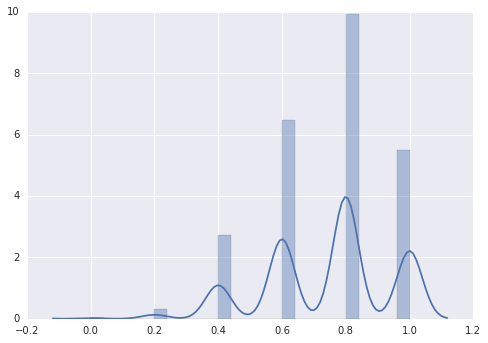

In [14]:
%matplotlib inline
import seaborn as sb
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(combine, label, train_size=0.75)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sb.distplot(model_accuracies)

In [15]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

decision_tree_classifier = DecisionTreeClassifier()
parameter_grid = {'max_depth': [1, 2, 3, 4, 5], 'max_features': [3, 6, 9, 11, 13]}
cross_validation = StratifiedKFold(label, n_folds=5)
grid_search = GridSearchCV(decision_tree_classifier, param_grid=parameter_grid, cv=cross_validation)

grid_search.fit(combine, label)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9
Best parameters: {'max_features': 9, 'max_depth': 4}


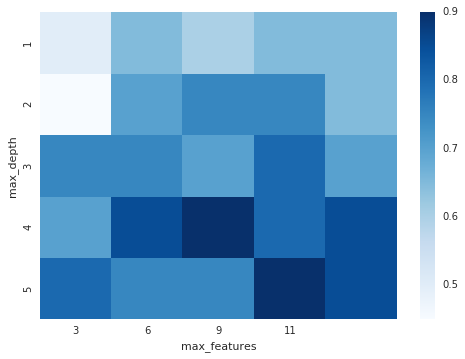

In [21]:
import matplotlib.pyplot as plt
grid_visualization = []

for grid_pair in grid_search.grid_scores_:
    grid_visualization.append(grid_pair.mean_validation_score)
    
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (5, 5)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')